### Import Neccessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso ,Ridge , LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df = pd.read_excel('premiums_rest.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
df['genetical_risk'] = 0

In [4]:
df.shape

(29904, 14)

In [6]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0


### Handling NA Values

In [7]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


In [11]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-1, -3])

In [12]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [13]:
numeric_columns = df.select_dtypes(['int64','float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

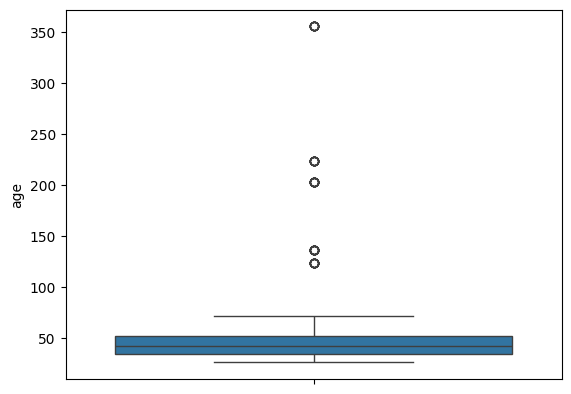

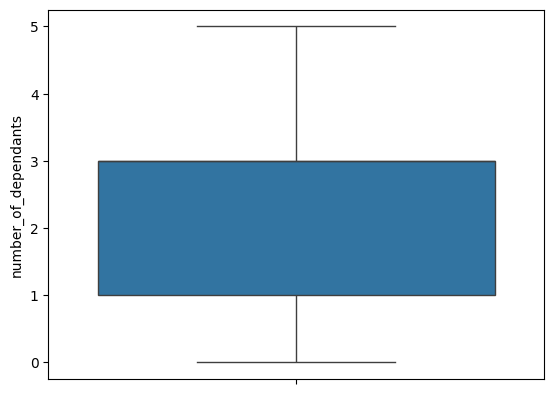

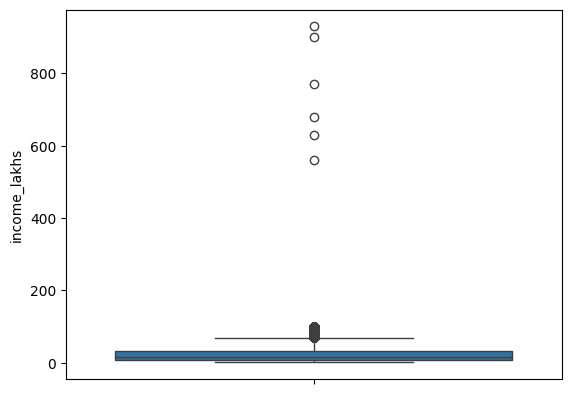

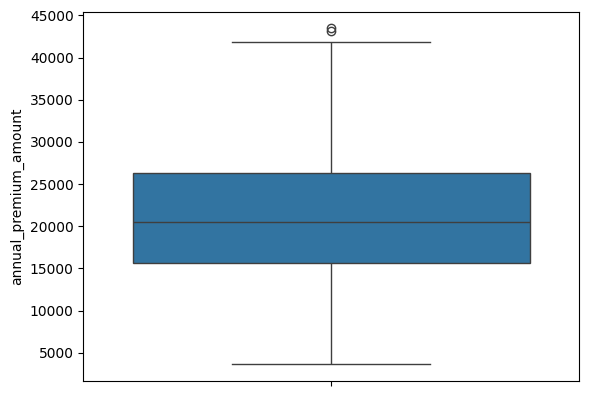

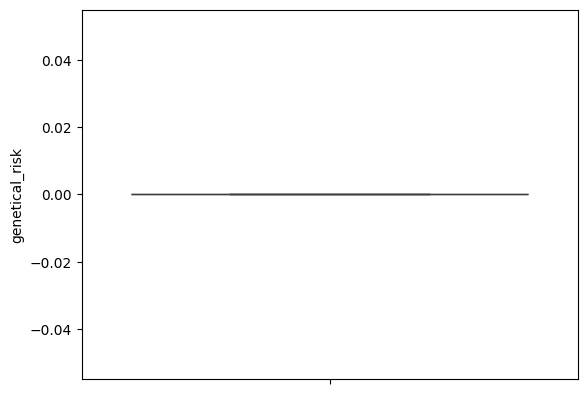

In [14]:
for col in numeric_columns:
    sns.boxplot(df[col])
    plt.show()

In [15]:
df[df['age'] > 100 ]['age'].unique()

array([224, 124, 136, 203, 356])

In [16]:
df1 = df[df['age']<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


In [17]:
def get_iqr_bounds(col) :
    Q1,Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound

In [18]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

In [19]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [20]:
df1[df1.income_lakhs > quantile_threshold].shape

(6, 14)

In [22]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


### Exploratory Data Analysis (EDA)

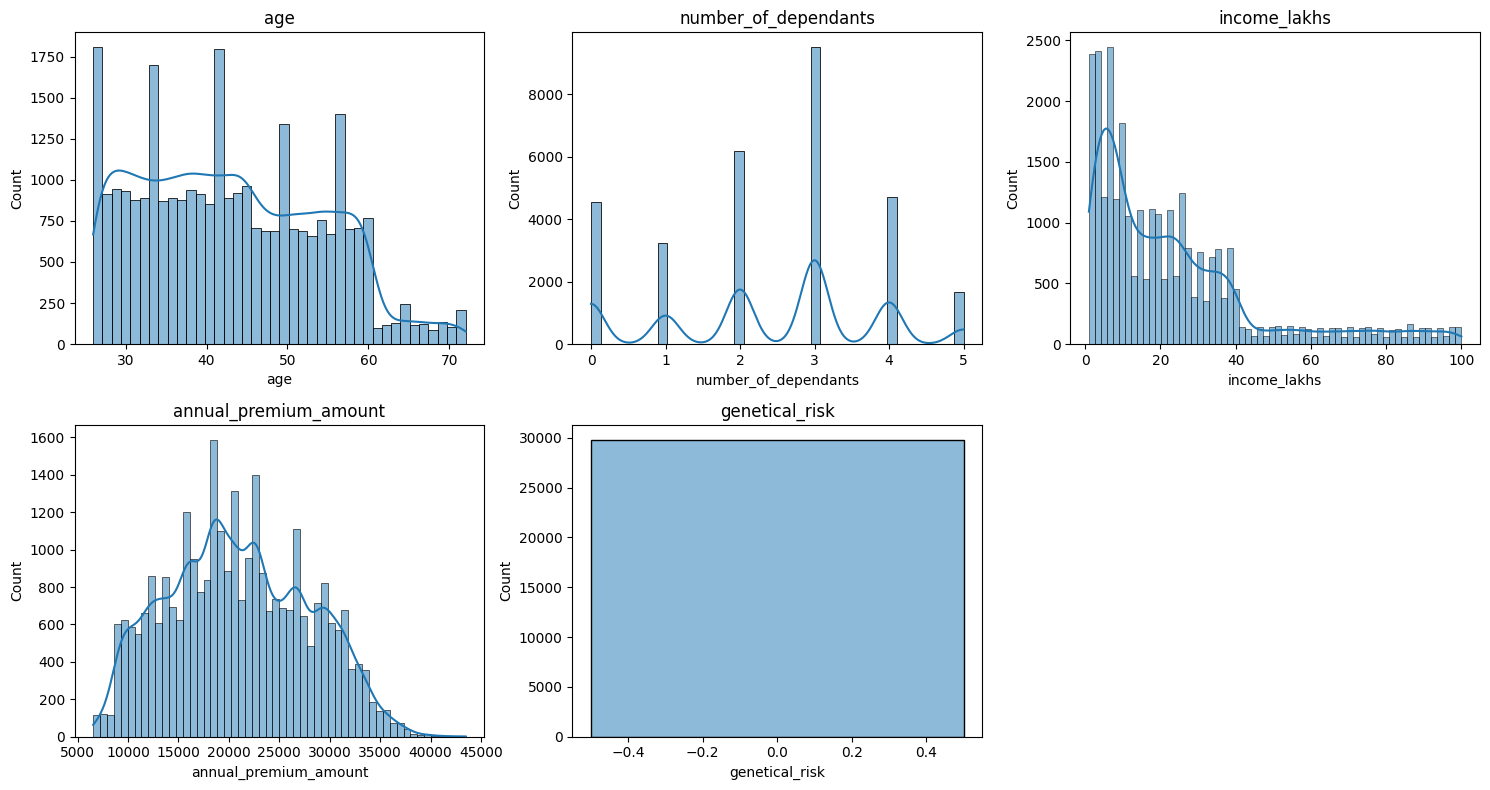

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 cols
axes = axes.flatten()

# Loop through each column and subplot
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Hide the last empty subplot (if numeric_columns has only 5)
if len(numeric_columns) < len(axes):
    for j in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

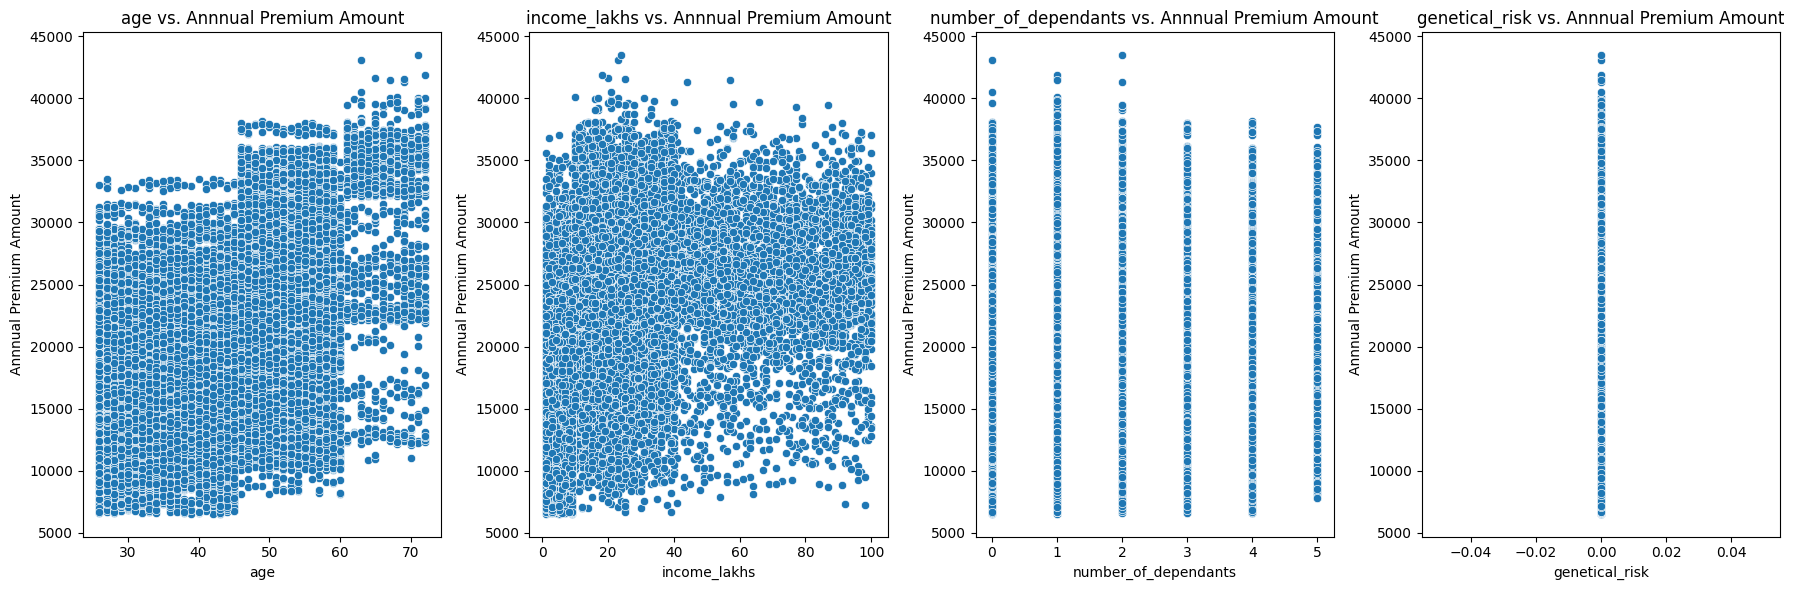

In [24]:
numeric_features = ['age','income_lakhs','number_of_dependants','genetical_risk']

fig,axes = plt.subplots(1,len(numeric_features),figsize=(18,6))

for ax,col in zip(axes,numeric_features):
    sns.scatterplot(x=df2[col],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{col} vs. Annnual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annnual Premium Amount')

plt.tight_layout()
plt.show()

In [25]:
categorical_cols = df2.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [26]:
for col in categorical_cols:
    print(col,':',df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [27]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Not Smoking':'No Smoking',
    'Does Not Smoke':'No Smoking'
},inplace=True)
df2['smoking_status'].unique() 

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [28]:
pct_count = df['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549187
Female    0.450813
Name: proportion, dtype: float64

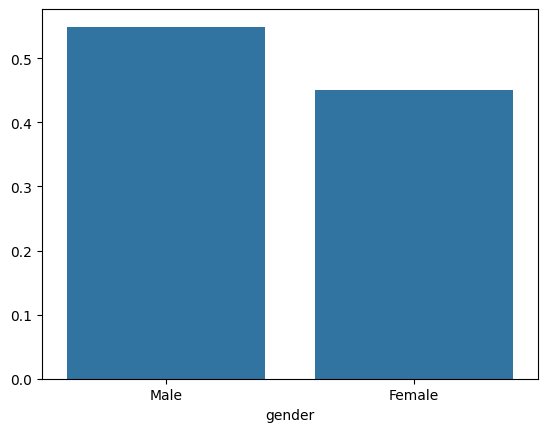

In [29]:
sns.barplot(x=pct_count.index,y=pct_count.values)
plt.show()

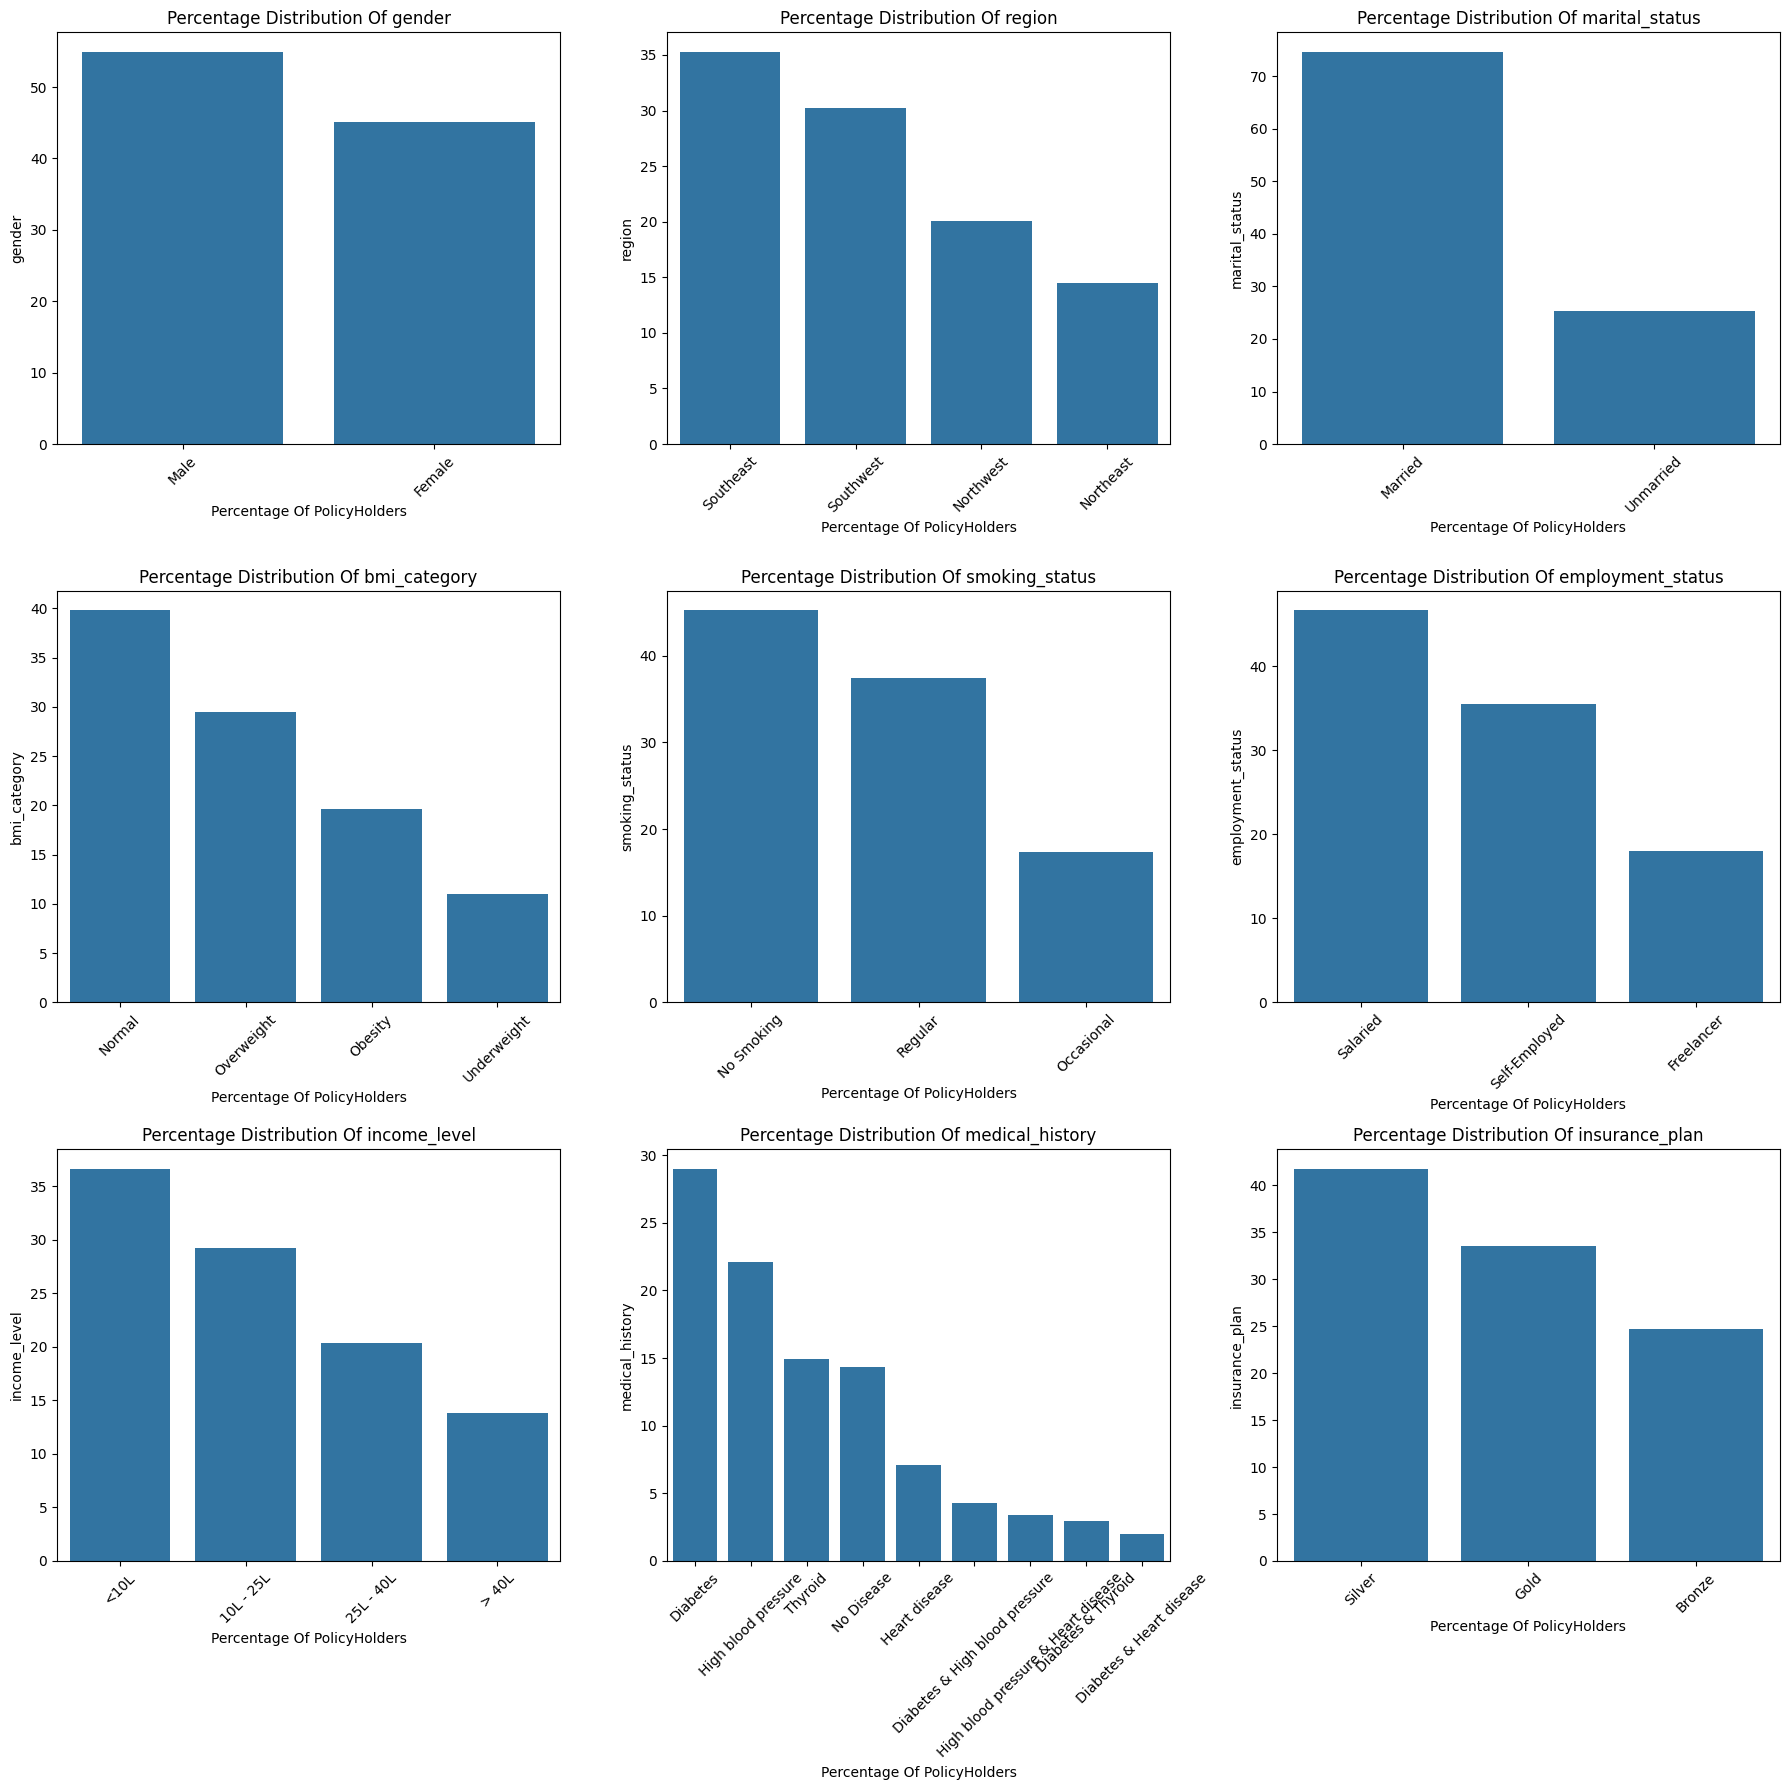

In [30]:
fig , axes = plt.subplots(3,3,figsize=(18,18))
axes = axes.flatten()

for ax,col in zip(axes,categorical_cols):
    category_counts = df2[col].value_counts(normalize=True)*100

    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(f'Percentage Distribution Of {col}')
    ax.set_xlabel('Percentage Of PolicyHolders')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


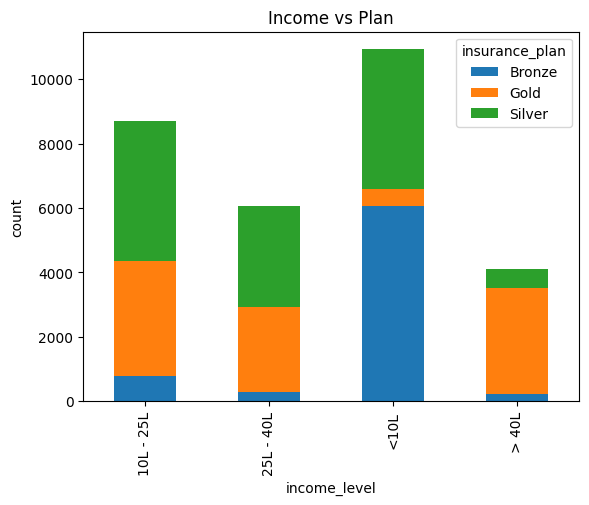

In [31]:
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar',stacked=True)
plt.title('Income vs Plan')
plt.ylabel('count')
plt.show()

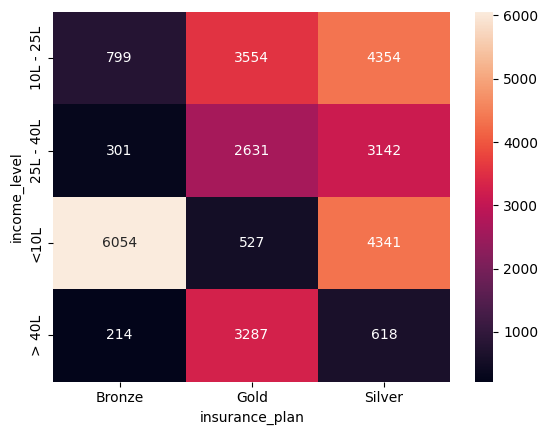

In [32]:
sns.heatmap(crosstab,annot=True,fmt='d')
plt.show()

### Feature Engineering

In [33]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [34]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [35]:
risk_scores = {
    'diabetes' :6,
    'heart disease':8,
    'high blood pressure': 6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

In [36]:
df2[['disease1','disease2']] = df2['medical_history'].str.split(' & ',expand=True).apply(lambda x : x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None


In [37]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2'] :
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score-min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571


In [38]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [39]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [40]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [41]:
df2['income_level'] = df2['income_level'].map({'<10L':1,'10L - 25L':2,'> 40L':3 ,'25L - 40L':4 })
df2['income_level'].unique()

array([1, 2, 3, 4])

In [42]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571


In [43]:
nominal_cols = ['gender','region','marital_status','bmi_category','smoking_status','employment_status']

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype='int')
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1


In [44]:
df4 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


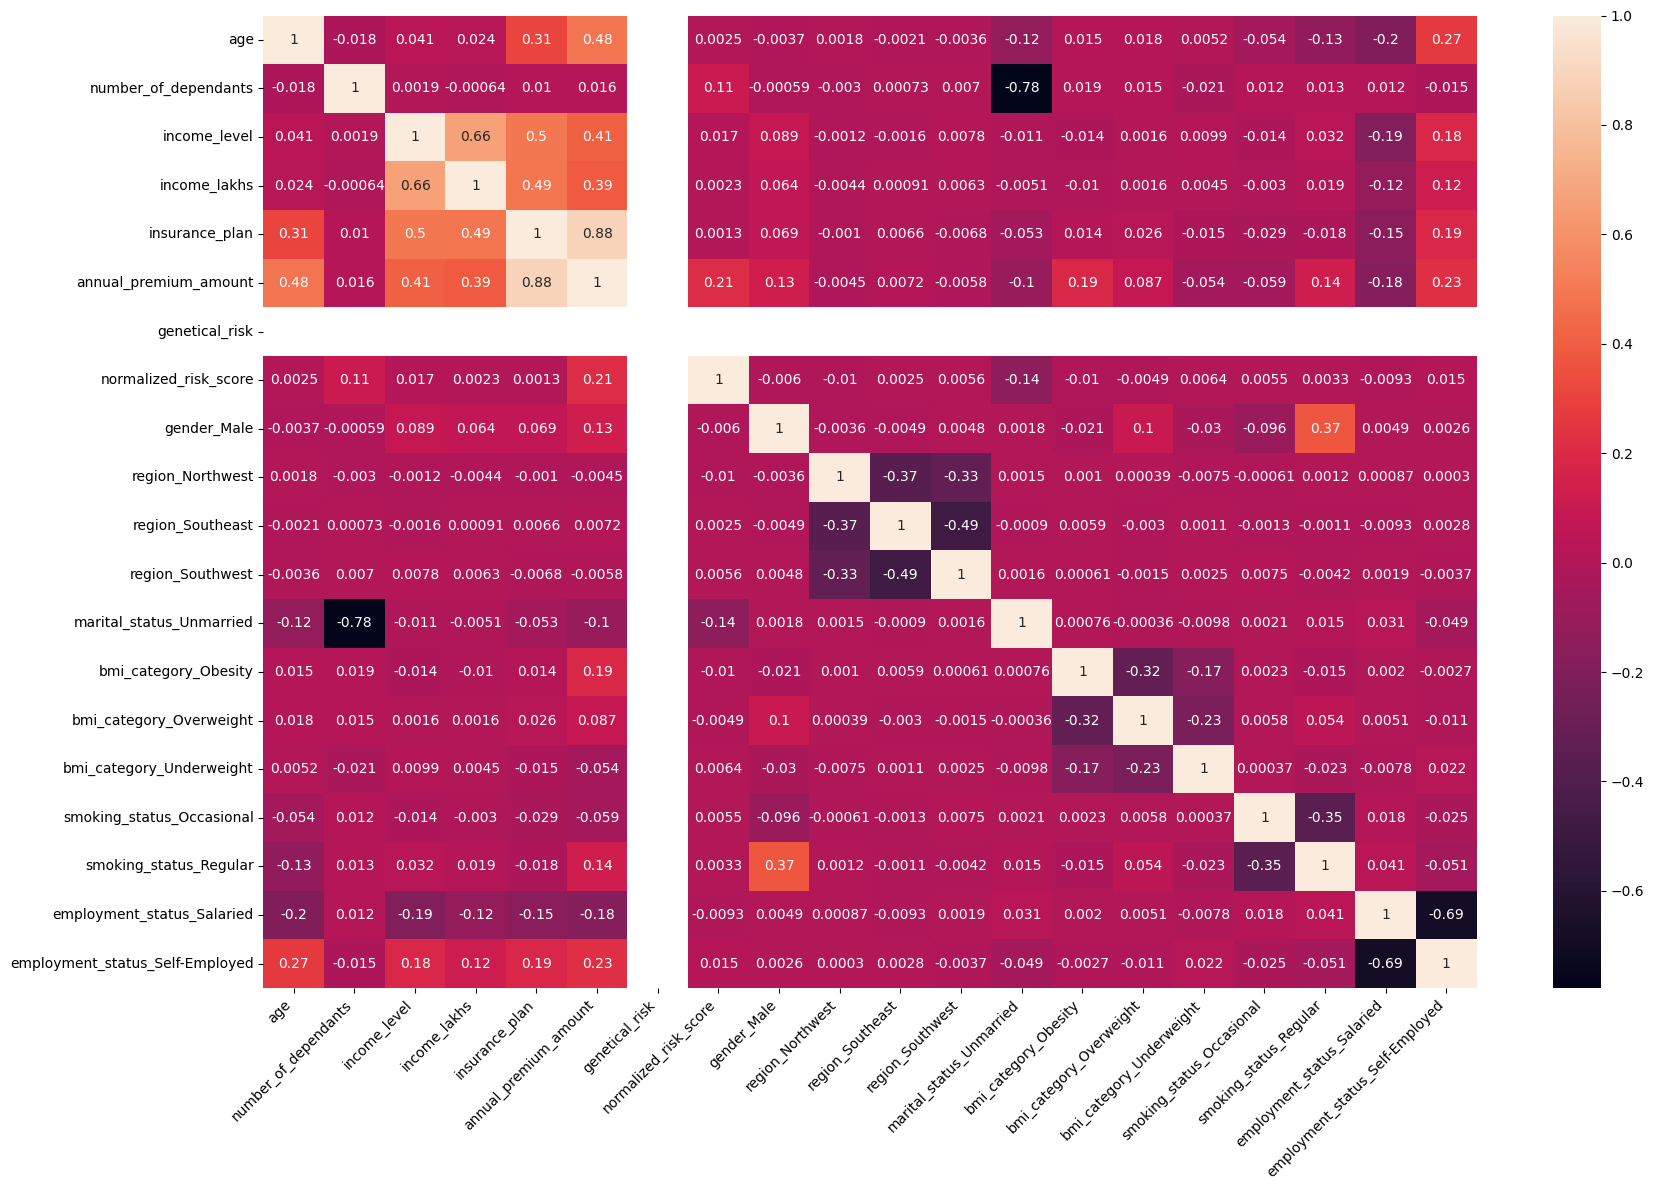

In [45]:
cm = df4.corr()

plt.figure(figsize=(18,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
df4.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0


In [47]:
X = df4.drop('annual_premium_amount',axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan','genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.393077,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.378150,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
calculate_vif(X.drop('income_level',axis=1))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [50]:
X_redcued = X.drop('income_level',axis=1)
X_redcued.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Training

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X_redcued,y,test_size=0.3,random_state=10)

print('X train :',X_train.shape)
print('X test :',X_test.shape)
print('y train :',y_train.shape)
print('y test :',y_test.shape)

X train : (20875, 18)
X test : (8947, 18)
y train : (20875,)
y test : (8947,)


In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)
train_score,test_score

(0.9534163989489616, 0.9538448451629948)

In [53]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print('LinearRegression ==> MSE : ',mse_lr,'RMSE :',rmse_lr)

LinearRegression ==> MSE :  2183844.360312456 RMSE : 1477.7835972538253


In [54]:
model_lr.intercept_

np.float64(5935.981289344609)

In [55]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
           0.        ,  6053.6241234 ,    37.55826883,   -55.25087215,
         -19.62254288,   -22.28967559,  -700.32019985,  3926.8127061 ,
        1979.45604663,   612.86623617,   837.3951011 ,  2800.66184334,
         -45.49136706,   243.07842087])

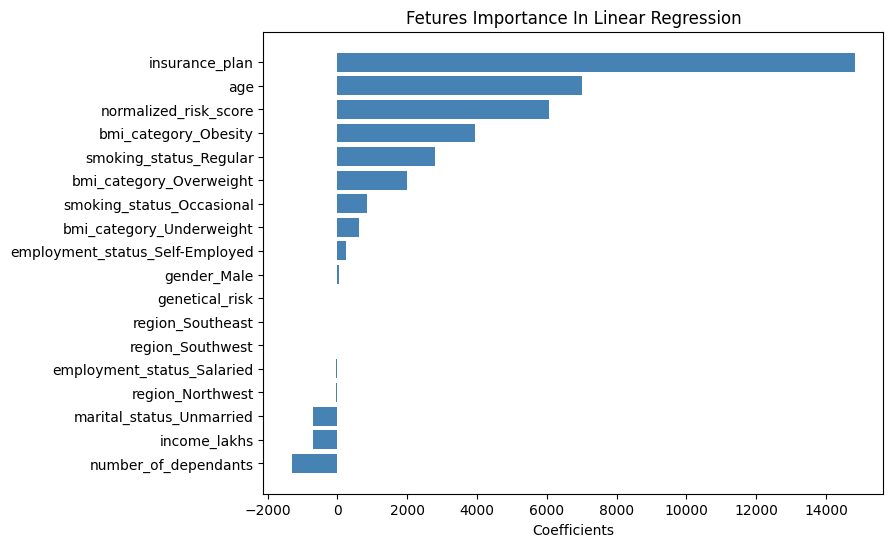

In [56]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_df.index,coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficients')
plt.title('Fetures Importance In Linear Regression')
plt.show()

In [57]:
model_rg = Ridge(alpha=5)
model_rg.fit(X_train,y_train)
model_rg.score(X_test,y_test)
train_score = model_rg.score(X_train,y_train)
test_score = model_rg.score(X_test,y_test)
train_score,test_score

(0.9534122791634791, 0.9538458522918216)

In [58]:
y_pred = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test,y_pred)
rmse_rg = np.sqrt(mse_rg)
print('Ridge ==> MSE : ',mse_rg,'RMSE :',rmse_rg)

Ridge ==> MSE :  2183796.7077237833 RMSE : 1477.7674741730457


In [59]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)
train_score = model_xgb.score(X_train,y_train)
test_score = model_xgb.score(X_test,y_test)
train_score,test_score

(0.9986370801925659, 0.9979538321495056)

In [60]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test,y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print('XGBoostRegresion ==> MSE : ',mse_xgb,'RMSE :',rmse_xgb)

XGBoostRegresion ==> MSE :  96814.21875 RMSE : 311.1498332797239


In [61]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5]
}

random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.9970577955245972)

In [62]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [63]:
best_model = random_search.best_estimator_

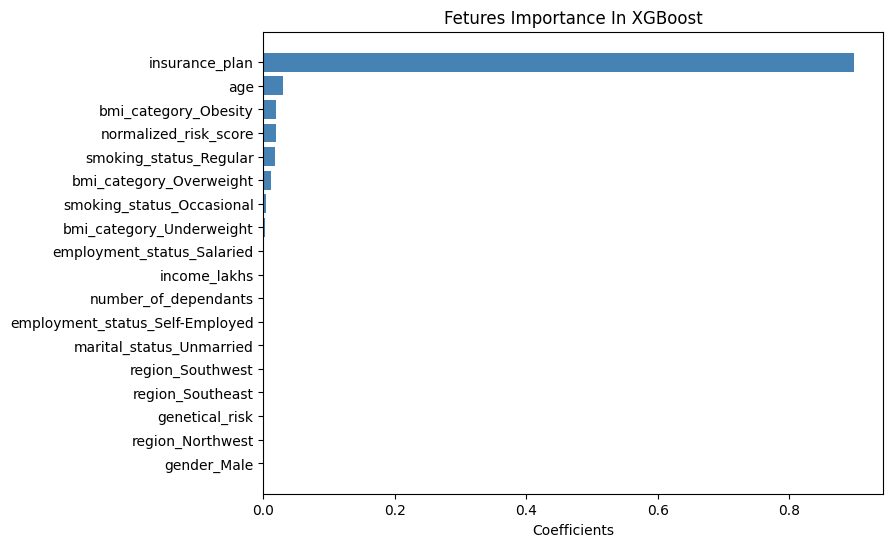

In [64]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_df.index,coef_df['Coefficients'],color='steelblue')
plt.xlabel('Coefficients')
plt.title('Fetures Importance In XGBoost')
plt.show()

### Error Analysis

In [65]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


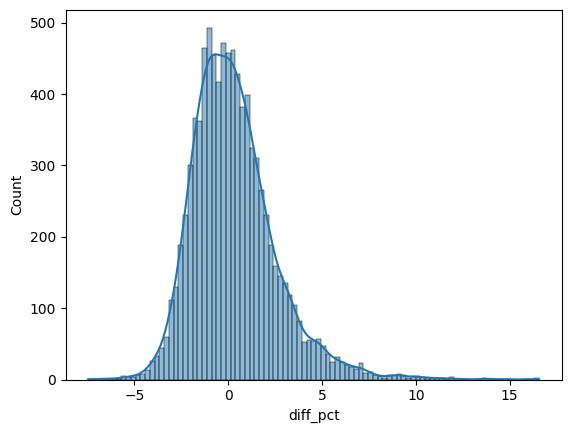

In [66]:
sns.histplot(results_df['diff_pct'],kde=True)
plt.show()

In [67]:
results_df.shape

(8947, 4)

In [68]:
extreme_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_threshold]
extreme_results_df.shape

(29, 4)

In [69]:
extreme_errors_pct = extreme_results_df.shape[0]*100 / results_df.shape[0]
extreme_errors_pct

0.32413099362914943

In [70]:
results_df[np.abs(results_df['diff_pct']) > 50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct


In [71]:
X_test.index

Index([19713, 14750, 19932, 29643, 17076, 20314, 24893, 26722, 25844, 10731,
       ...
       10637,  1224, 17046, 19228,  9275,  3387,  7858,  9744,  4849,  8986],
      dtype='int64', length=8947)

In [72]:
extreme_results_df.index

Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [73]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0


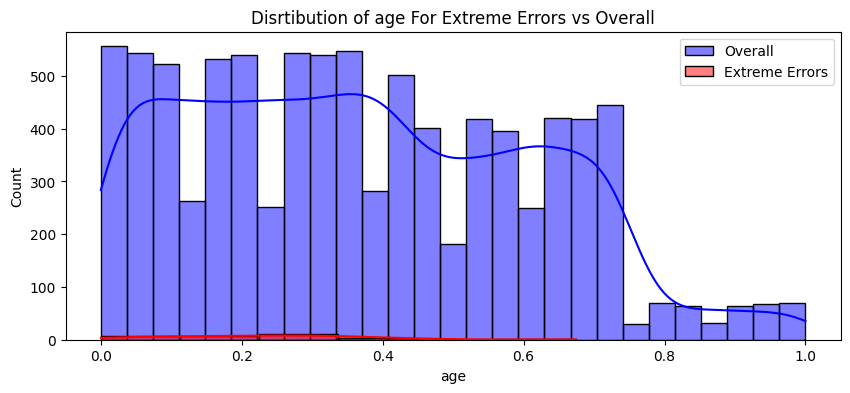

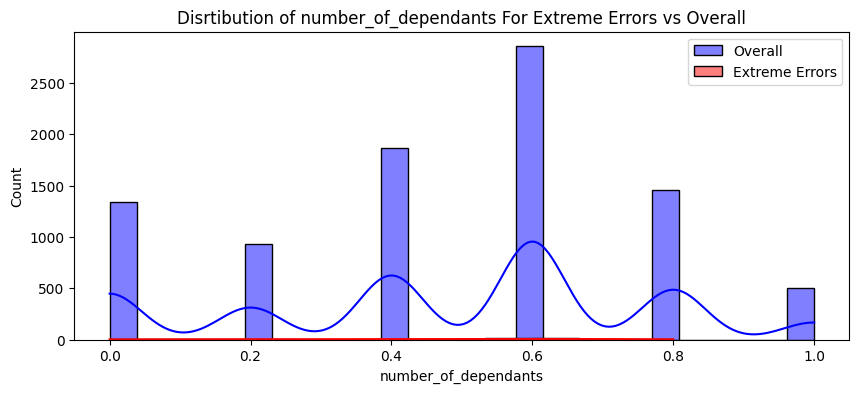

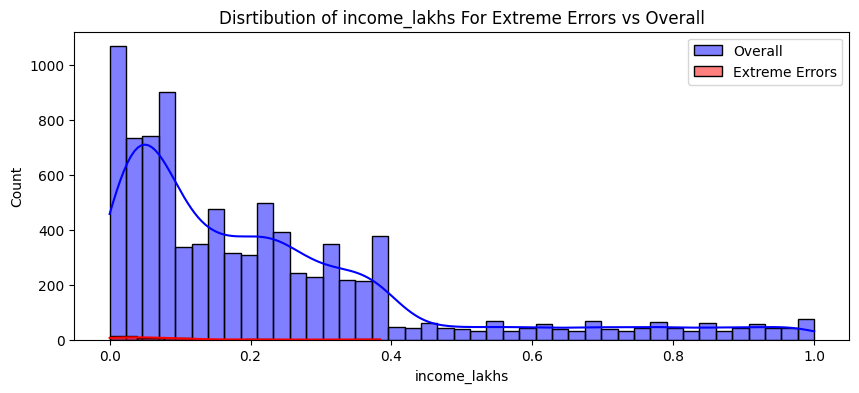

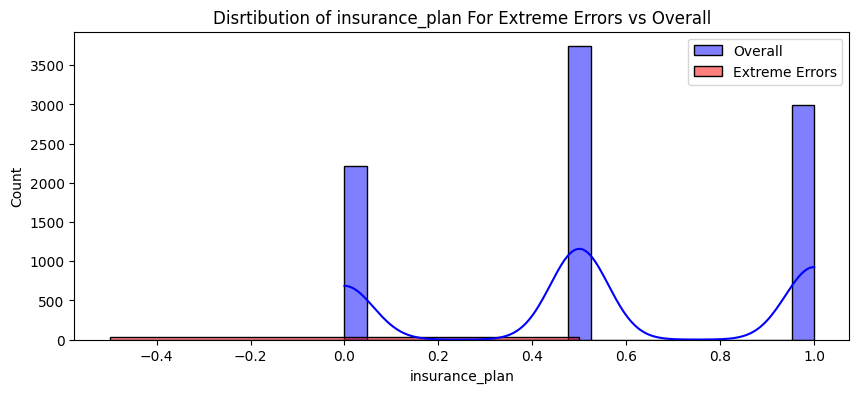

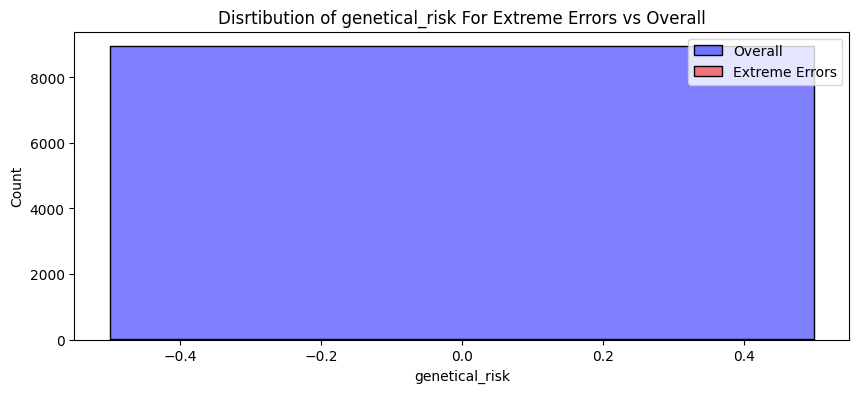

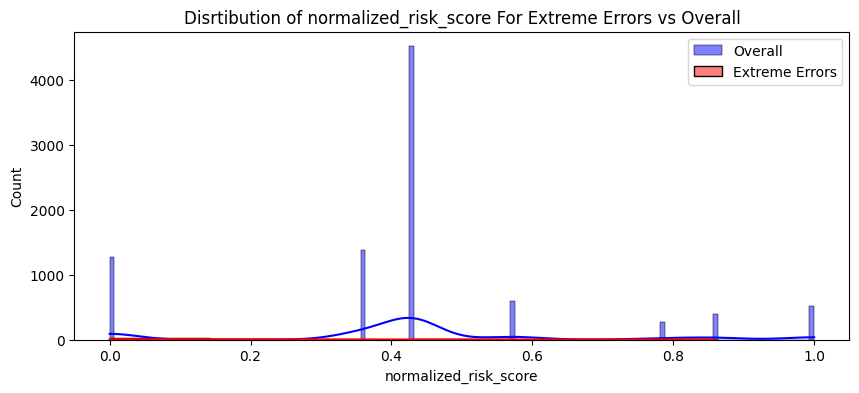

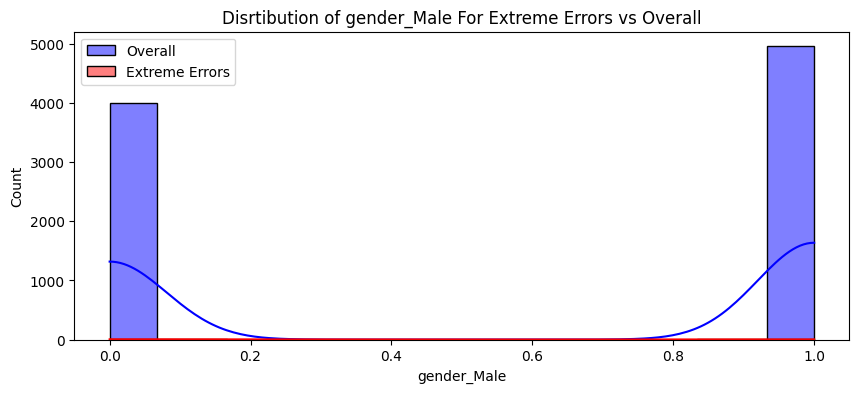

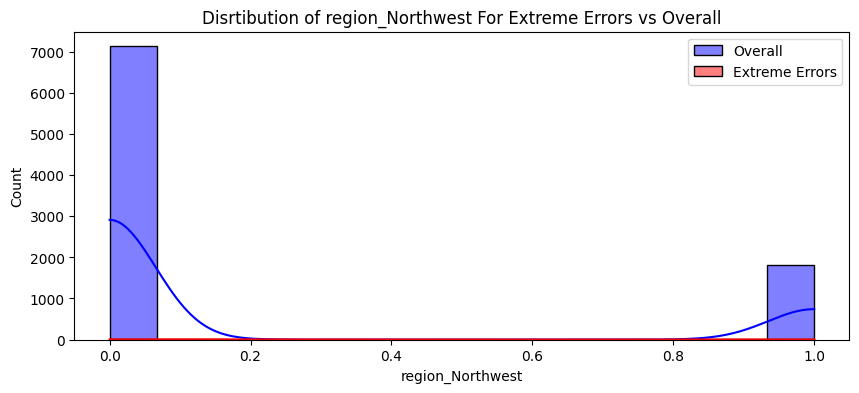

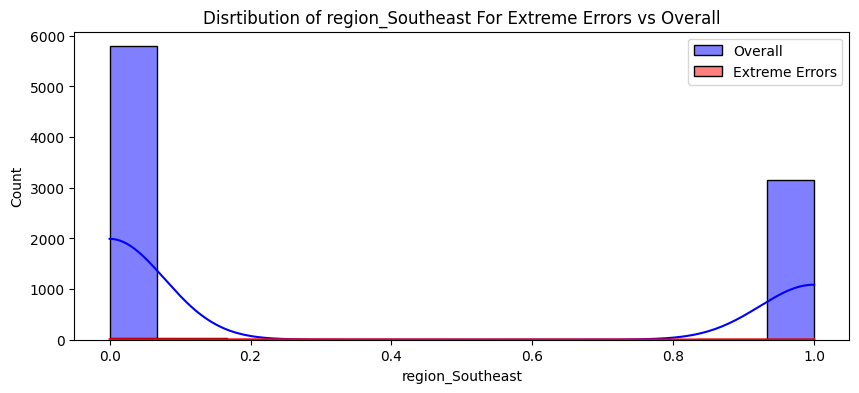

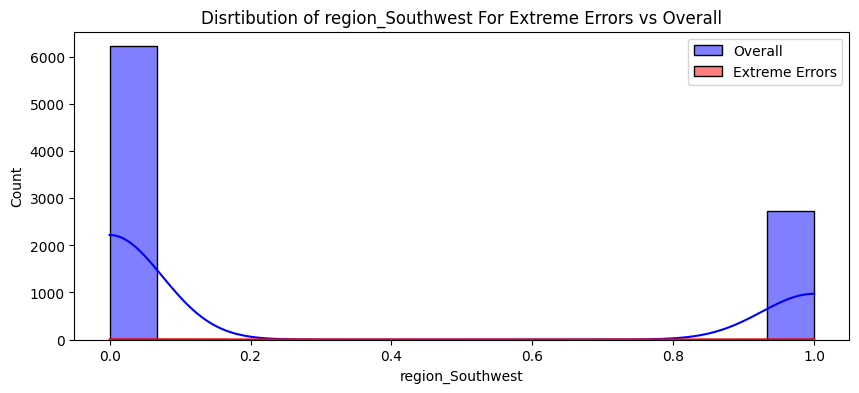

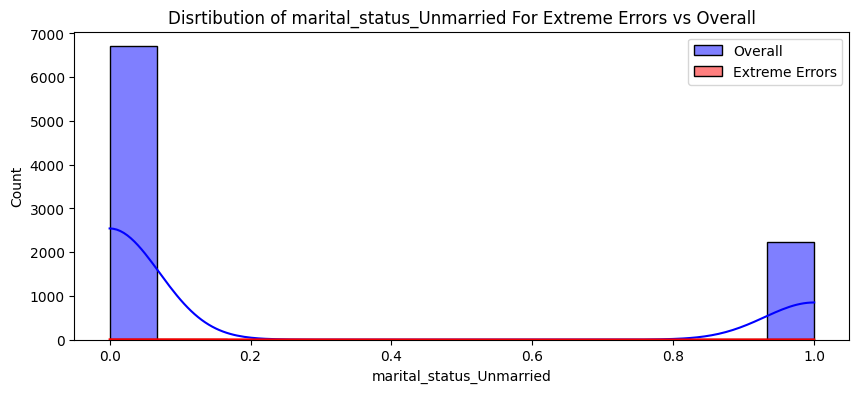

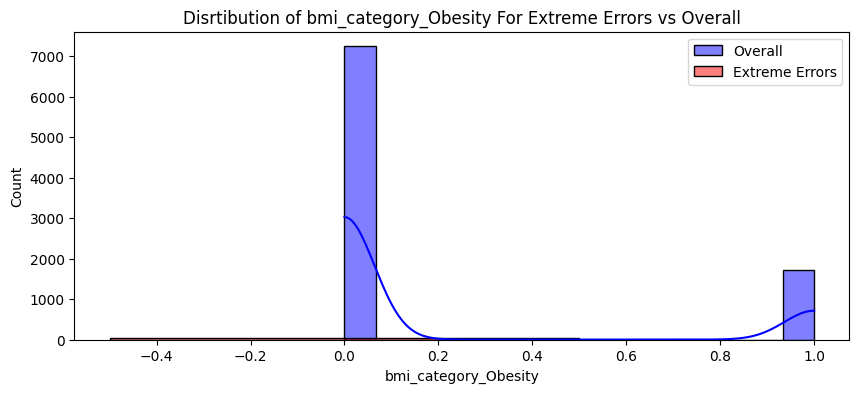

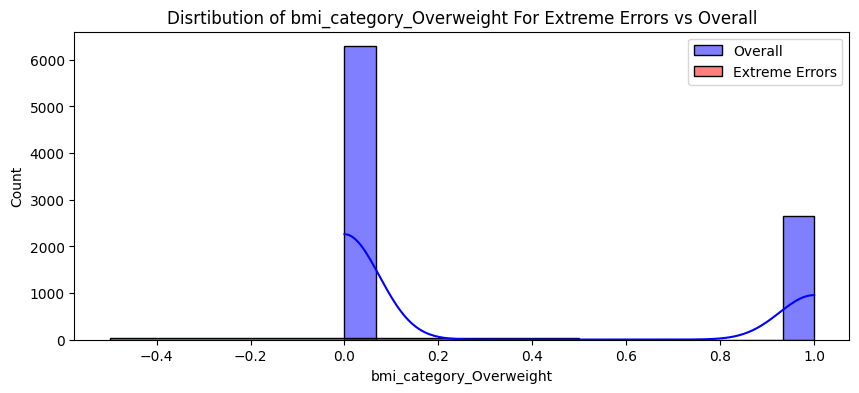

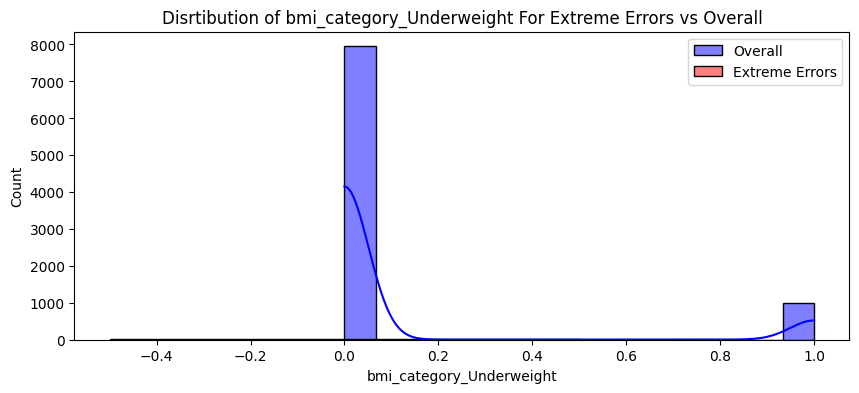

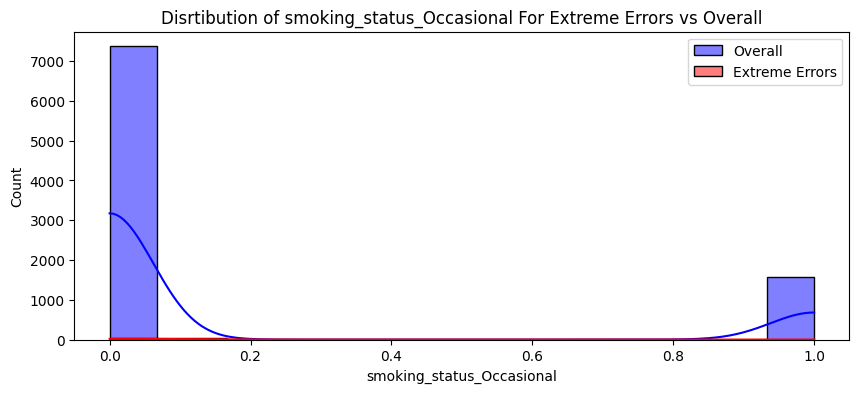

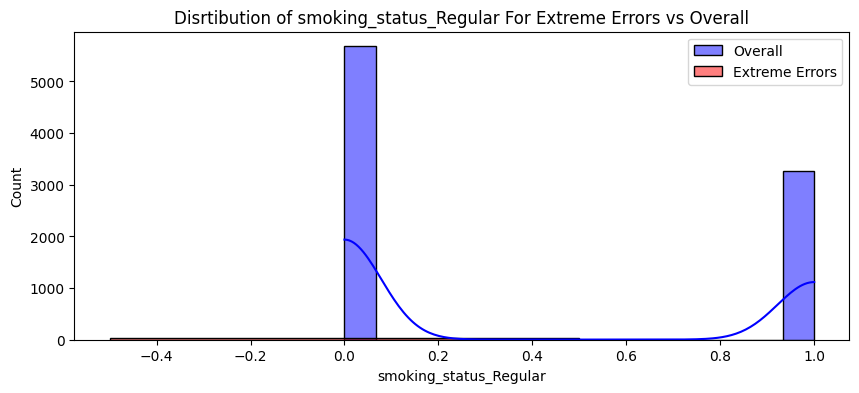

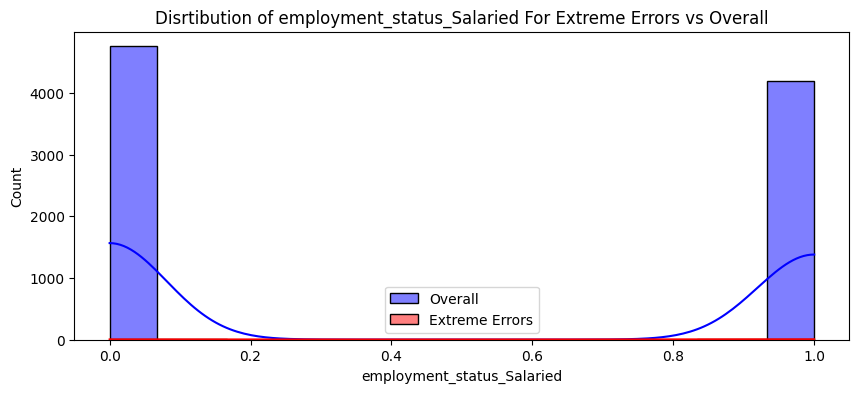

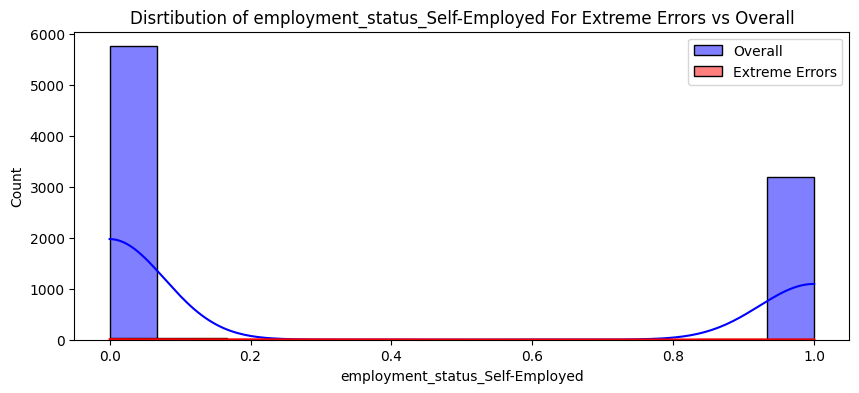

In [74]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_test[feature],kde=True,color='blue',alpha=0.5,label='Overall')
    sns.histplot(extreme_errors_df[feature],color='red',kde=True,label='Extreme Errors')
    plt.title(f'Disrtibution of {feature} For Extreme Errors vs Overall')
    plt.legend()
    plt.show()

In [75]:
extreme_errors_df.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [76]:
extreme_errors_df['income_level'] = 0

In [77]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk
0,27.0,3.0,1.0,6.0,1.0,0.0
1,40.0,3.0,1.0,9.0,1.0,0.0
2,41.0,3.0,1.0,2.0,1.0,0.0
3,42.0,1.0,1.0,9.0,1.0,0.0
4,28.0,3.0,1.0,3.0,1.0,0.0


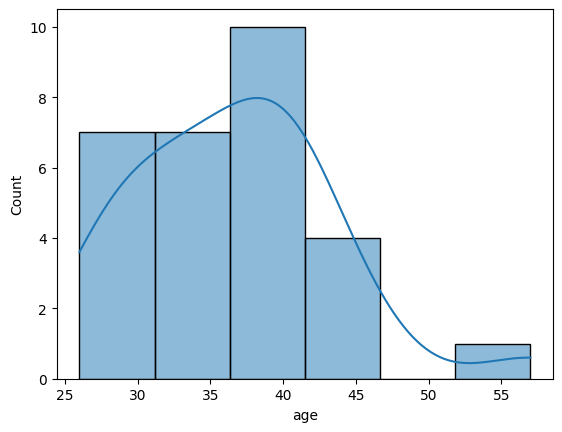

In [78]:
sns.histplot(df_reversed['age'],kde=True)
plt.show()

In [79]:
df_reversed['age'].quantile(0.97)

np.float64(47.760000000000005)

In [80]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

### Export The Model

In [82]:
from joblib import dump
dump(best_model,'artifacts/model_rest.joblib')
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale':cols_to_scale
}
dump(scaler_with_cols,'artifacts/scaler_rest.joblib')

['artifacts/scaler_rest.joblib']